<a href="https://www.kaggle.com/code/nurulsakinah/titanic-eda?scriptVersionId=195252558" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Introduction
Aim : use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

Features: <br>
survival: Survival status (0 = No, 1 = Yes) <br>
pclass: Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd) <br>
sex: Gender <br>
age: Age in years <br>
sibsp: Number of siblings or spouses aboard the Titanic <br>
parch: Number of parents or children aboard the Titanic <br>
ticket: Ticket number <br>
fare: Passenger fare <br>
cabin: Cabin number <br>
embarked: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton) <br>

# 2. Import libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
# ignore warning on infin
import warnings
warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import accuracy_score


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# 3. Load the dataset

In [2]:
# read file
df = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')

# 4. Exploratory Data Analysis


In [3]:
### CREATE NEW FEATURES
def cal_transform_family_size(df):
    """
    Calculate family size and categorize it into 'alone', 'small', and 'large'.
    """
    # Calculate family size
    df['family_size'] = df['SibSp'] + df['Parch'] + 1
    
    # Categorize family size
    def transform_family_size(num):
        if num == 1:
            return 'alone'
        elif 1 < num < 5:
            return 'small'
        else:
            return 'large'
    
    df['family_size'] = df['family_size'].apply(transform_family_size)
    return df


def add_person_column(df):
    """
    Adds a 'Person' column to categorize individuals as 'male', 'female', or 'child'.
    """
    # Vectorized operation to create 'Person' column
    df['Person'] = df['Age'].apply(lambda x: 'child' if x < 16 else None)
    df['Person'].fillna(df['Sex'], inplace=True)
    
    return df

In [4]:
print(df.shape)
df.head(10)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [5]:
def missing_values(df):
    ''' Calculate Null Values and Their Percentages'''

    missing_count = df.isnull().sum()
    value_count = df.isnull().count()
    missing_percentage = round(missing_count / value_count * 100, 2)
    missing_df = pd.DataFrame({"count": missing_count, "percentage": missing_percentage})
    return missing_df

missing_values(df)

,count,percentage
PassengerId,0,0.00
Survived,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
Age,177,19.87
SibSp,0,0.00
Parch,0,0.00
Ticket,0,0.00
Fare,0,0.00


Features Age, Cabin and Embarked has missing values with Cabin the most. This need to be dealt before building the model.

In [6]:
# Summary of Numeric Features 

def numeric_summary(df):
    obs = df.shape[0]
    
    numeric_df = df.select_dtypes(include='number')
    summary_df = pd.DataFrame({
        'Dtype': numeric_df.dtypes, 
        'Counts': numeric_df.apply(lambda x: x.count()), 
        'Nulls': numeric_df.apply(lambda x: x.isnull().sum()), 
        'NullPercent': (numeric_df.isnull().sum() / obs) * 100,
        'Mean' : numeric_df.mean(),
        'Min': numeric_df.min(),
        'Max': numeric_df.max(),
        'Uniques': numeric_df.apply(lambda x: x.unique().shape[0]),
        'UniqueValues': numeric_df.apply(lambda x: list(x.unique()) if x.nunique() <= 10 else '-')
    })
    
    return summary_df


numeric_summary(df)

,Dtype,Counts,Nulls,NullPercent,Mean,Min,Max,Uniques,UniqueValues
PassengerId,int64,891,0,0.00000,446.000000,1.00,891.0000,891,-
Survived,int64,891,0,0.00000,0.383838,0.00,1.0000,2,"[0, 1]"
Pclass,int64,891,0,0.00000,2.308642,1.00,3.0000,3,"[3, 1, 2]"
Age,float64,714,177,19.86532,29.699118,0.42,80.0000,89,-
SibSp,int64,891,0,0.00000,0.523008,0.00,8.0000,7,"[1, 0, 3, 4, 2, 5, 8]"
Parch,int64,891,0,0.00000,0.381594,0.00,6.0000,7,"[0, 1, 2, 5, 3, 4, 6]"
Fare,float64,891,0,0.00000,32.204208,0.00,512.3292,248,-


We can see there's two label for the target with 1 as survived and 0 for died. Based on Survived column, only ~38% people survived the sinking.


## Univariate analysis

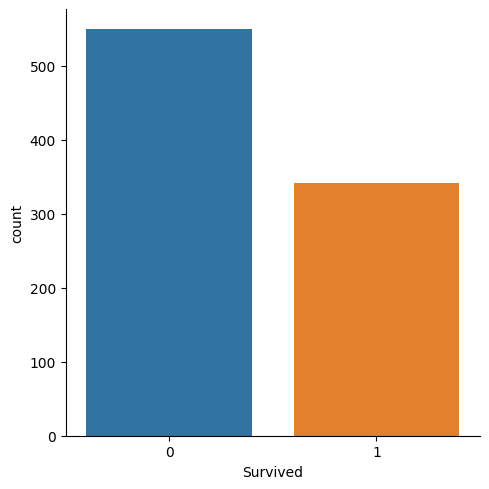

In [7]:
# Create plot to see the count of survived passengers 
sns.catplot(x='Survived',data=df,kind='count')

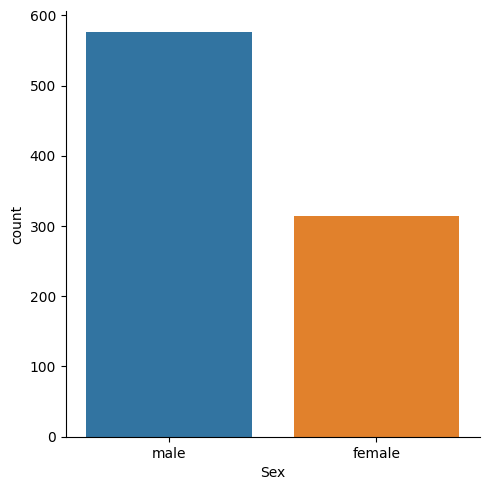

In [8]:
# Create plot to see male and female passengers 
sns.catplot(x='Sex',data=df,kind='count')

Plot shows there were more male passengers than female

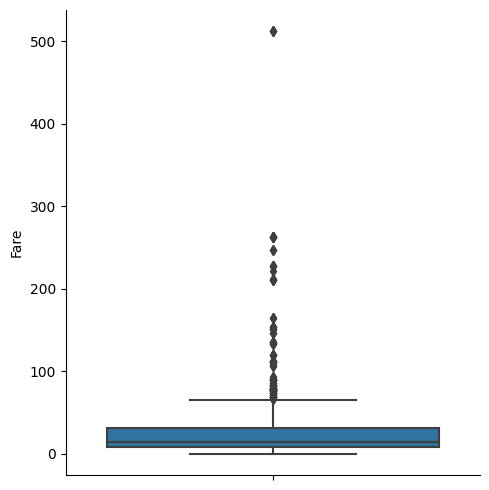

In [9]:
# Examine feature Fare
sns.catplot(df,y='Fare',kind='box')

We can see some outliers value in the fare feature with highest fare more than 500 

Check if the passengers with family or alone. <br>
The SibsSP attribute indicates the number of siblings or spouses a passenger had on board, while Parch represents the number of parents or children they traveled with.
Since we're mainly interested in whether a passenger had any family members on board, we can simplify things by creating a new column to capture this information.

In [10]:
# Apply the function to create family size
df = cal_transform_family_size(df)

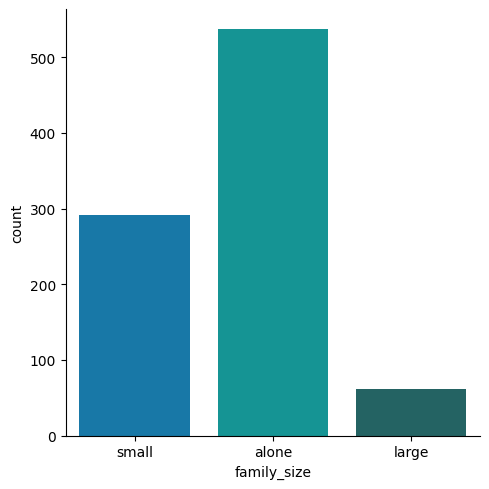

In [11]:
sns.catplot(x='family_size',data=df,palette='winter_d',kind='count')

Seems like most passengers travel alone

## Explore feature relationships

Let's see the family size and their classes 

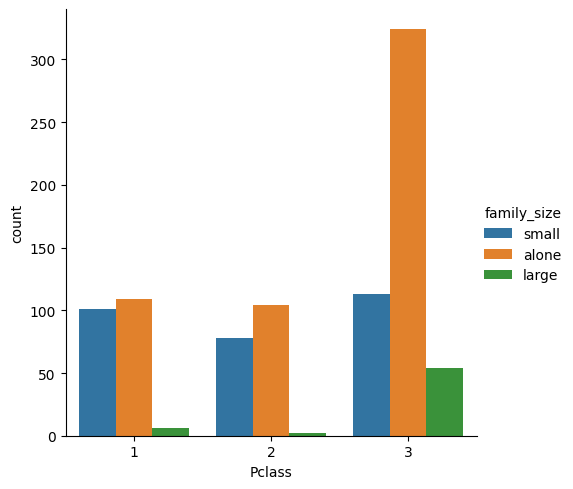

In [12]:
sns.catplot(x='Pclass',data=df,hue='family_size',kind='count')

The third class had the most number of passengers who boarded alone and with large family..

How does the distribution of male and female in different classes look like?

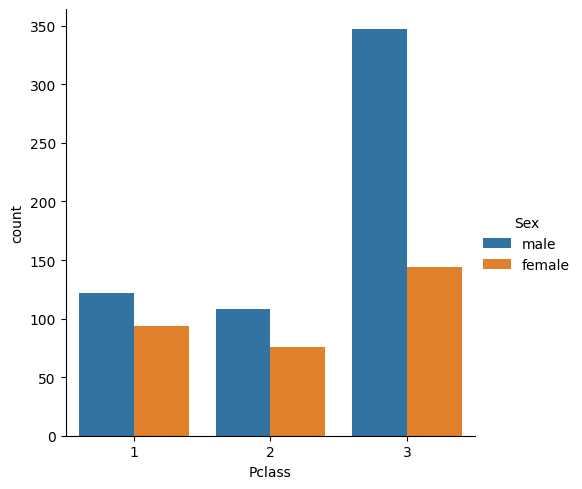

In [13]:
sns.catplot(x='Pclass',data=df,hue='Sex',kind='count')

In all classes, there are more male passengers than female. We would alaso like to see the child distribution in these classes. A new feature 'Person' will be created which consist of female, male and child

In [14]:
df= add_person_column(df)
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_size,Person
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,small,male
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,small,female
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,alone,female
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,small,female
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,alone,male


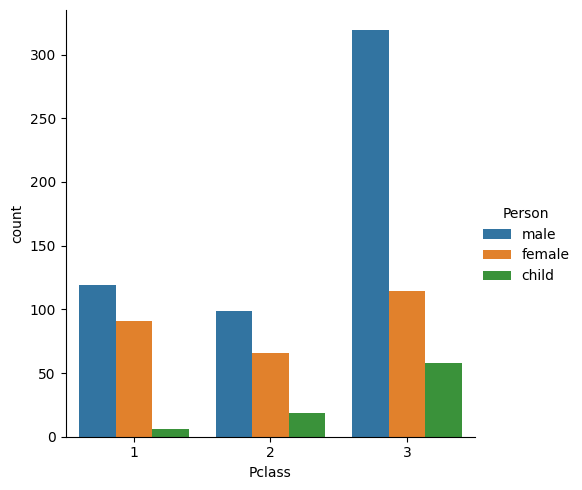

In [15]:
sns.catplot(x='Pclass',data=df,hue='Person',kind='count')

There are more children in the 3rd class and male passengers are the most in all 3 classes.

<Axes: >

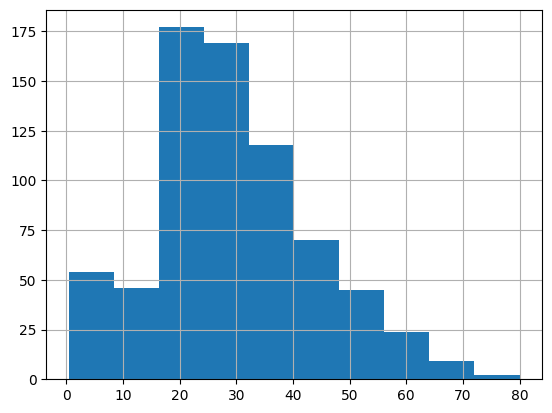

In [16]:
df['Age'].hist()

To see the distribution of passengers of different age groups, create a histogram. Most of the passengers age 20 to 30, with oldest at 80 years old. To get more in-depth analysis on the age feature, check the age distribution for different classes using Seaborn's Facetgrid.

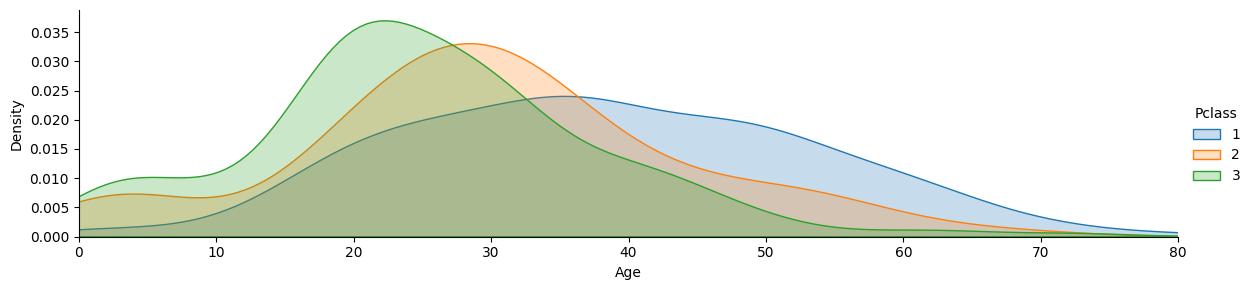

In [17]:
def plot_facetgrid(hue, x_axis):
    '''density plot between 2 features '''
    fig = sns.FacetGrid(df,hue=hue,aspect=4)
    fig.map(sns.kdeplot, x_axis, fill=True)
    oldest = df[x_axis].max()
    fig.set(xlim=(0,oldest))
    fig.add_legend()

    
plot_facetgrid('Pclass', 'Age')

We can clearly see that the first class passengers belonged more to the middle age groups, with very few children.Second and third class had more children, with relatively fewer older people.

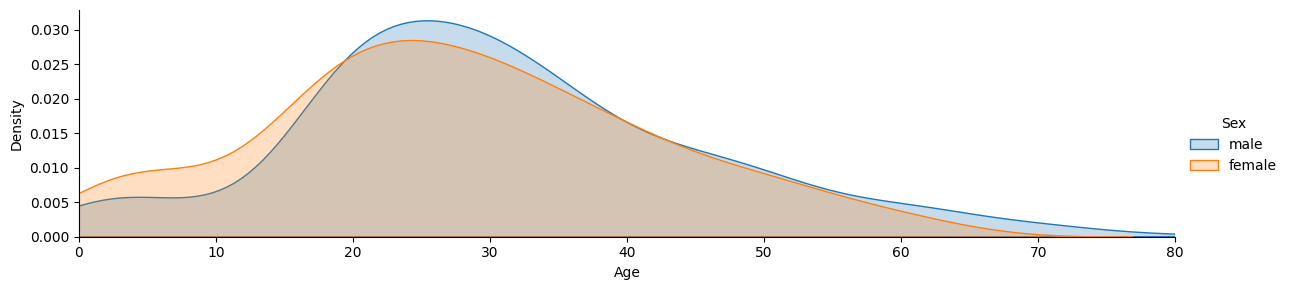

In [18]:
plot_facetgrid('Sex','Age')

There isnt much variation for age between male and female. However we can see that there are more younger female than male

<Axes: xlabel='Pclass', ylabel='Fare'>

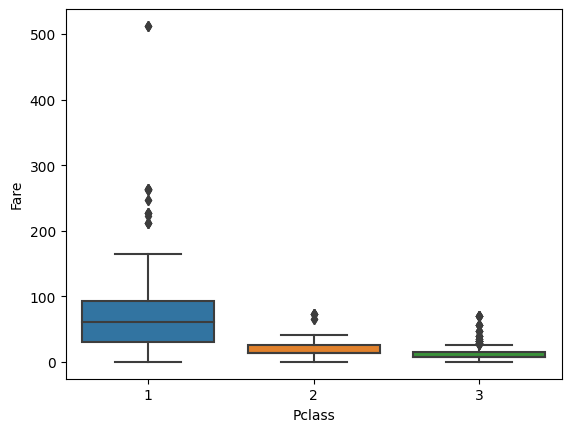

In [19]:
sns.boxplot(x='Pclass', y= 'Fare', data=df)

Passenger class 1 paid higher fares compared to class 2 & 3, with fare as high as 500. 

We can explore the pclass and cabin features to see if they can convey any information on the passengers. The cabin feature has highest missing values thus we can for now create another df omitting the missing rows and further explore the feature. From the cabin attribute, we can get the deck the passengers on. For example, a passenger on deck 'C' will have a cabin number in CXXX format, where XXX can be a room number.

In [20]:
# Because the cabin data was missing in a lot of cases, we can just drop it for now for this section.
deck_df = df.dropna(axis=0)

# Get deck from cabin numbers
def get_level(data):
    cabin = data['Cabin']
    # extract the first character which is the deck
    return cabin[0]

# apply the function
deck_df['deck']=deck_df.apply(get_level,axis=1)

deck_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_size,Person,deck
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,small,female,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,small,female,C
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,alone,male,E
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,small,child,G
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S,alone,female,C


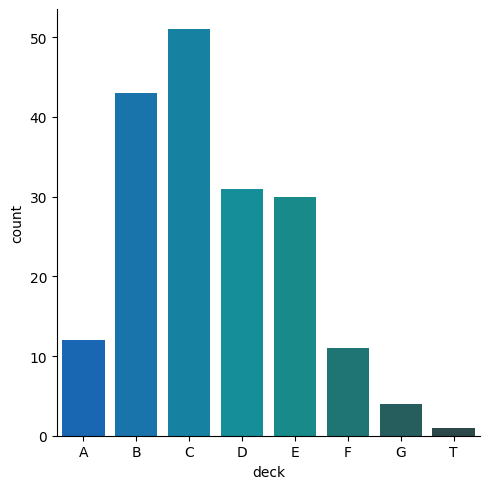

In [21]:
# Sort the DataFrame by 'level' alphabetically
deck_df = deck_df.sort_values(by='deck')

sns.catplot(x='deck',data=deck_df,palette='winter_d',kind='count')

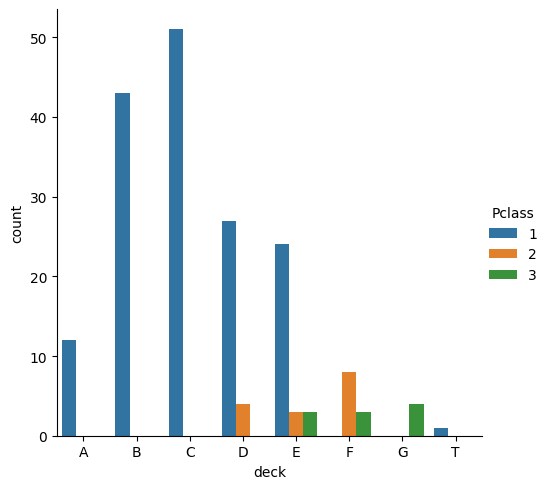

In [22]:
# Create the catplot
sns.catplot(x='deck', data=deck_df, hue='Pclass', kind='count')

Deck A,B,C has only the Pclass 1 and from deck E we can only start seeing Pclass 3. 
Deck G, on the other hand, is entirely occupied by third-class passengers. There is also an odd deck 'T' which contains 1 first class passenger.
This distribution further emphasizes the correlation between passenger class and deck assignment, with lower-class passengers being placed on the lower decks. However, we have to keep in mind that cabin information was missing for about 77% of the data.

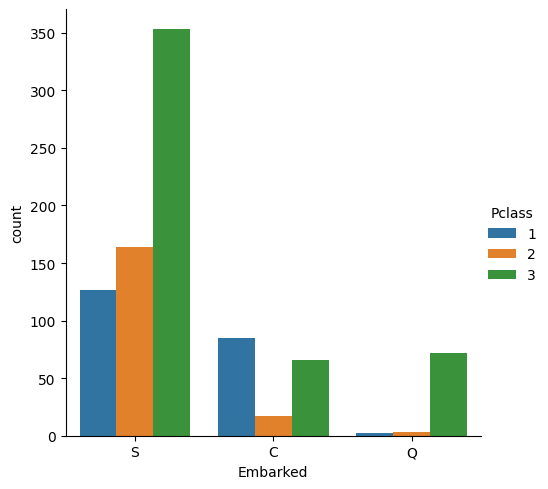

In [23]:
sns.catplot(x='Embarked',data=df,hue='Pclass',kind='count')

The majority of passengers boarded in Southampton. Interestingly, nearly all first and second-class passengers did not board in Queenstown, which may reflect the socio-economic status of Queenstown's population.

## Explore the Relationship Between Features and the Target Variable

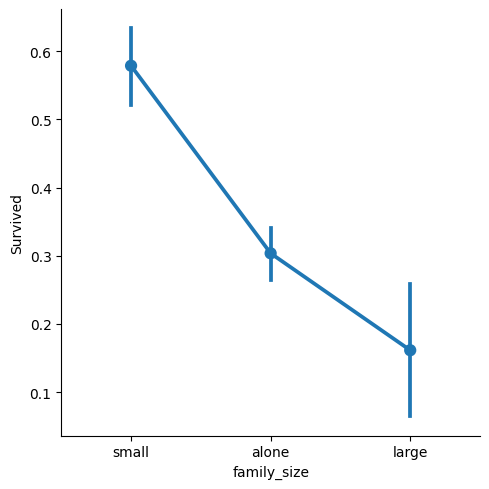

In [24]:
sns.catplot(x='family_size',y='Survived',data=df,kind='point')

Seems like those with small family had highest rate of survival. Meanwhile those with larger family had the lowest rate of survival.

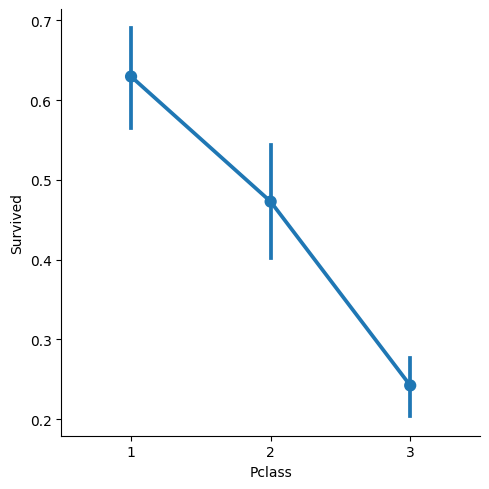

In [25]:
sns.catplot(x='Pclass',y='Survived',data=df,kind='point')

The plot reveals that lower-class passengers had a lower chance of survival. We previously observed that the 3rd class had a higher number of men compared to women and children, more than any other class.

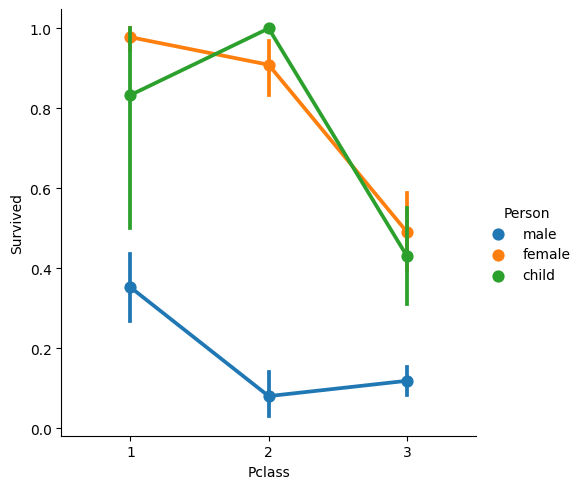

In [26]:
sns.catplot(x='Pclass',y='Survived',hue='Person',data=df, kind='point')

Across all classes, men had lower survival rates than women and children, as they were given less priority during rescue efforts. Overall, men, women, and children in the 3rd class had a significantly lower chance of survival compared to those in the 1st class.


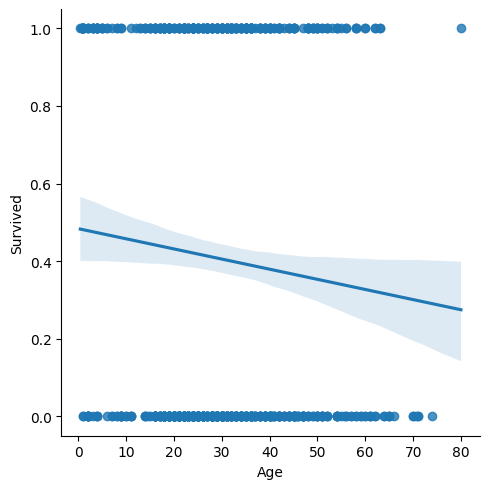

In [27]:
sns.lmplot(x='Age',y='Survived',data=df)

Younger passengers, particularly those aged 0-10, had a higher survival rate. Survival rates decrease with age, especially in the 20-40 age range. 

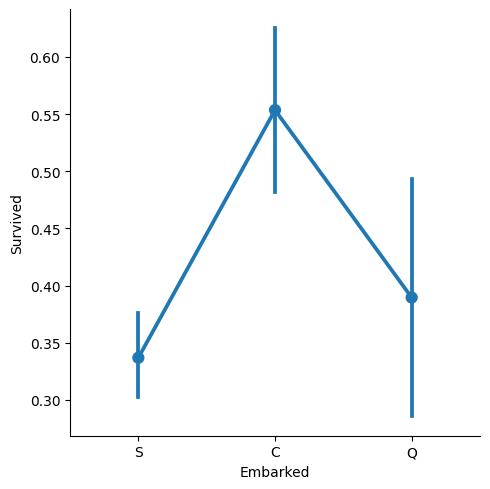

In [28]:
sns.catplot(x='Embarked',y='Survived',data=df,kind='point')

We can see passengers who boarded the ship at Cherbourg had higher rate of surviving.

## Summary of Insights from Exploratory Data Analysis


First-class passengers, females and child had a higher likelihood of survival. <br>
Passengers who boarded in Cherbourg had better survival rates. <br>
Traveling alone and with large family size reduced survival chances. <br>
Survival rates decrease with age, especially in the 20-40 age range. <br>


# Data Preprocessing

## Feature Selection
Features removed: <br>
SibSp and Parch will be deleted as we have created another feature 'family size'. <br>
Cabin has highest missing values thus we will remove it. <br>
PassengerId, Name will also be removed as it is just a unique identifier of the passengers. <br>
Ticket feature as we have information of the family size which tells us which passengers travel together. <br>
Sex as we have created another feature Person which tells if the passenger is a male, female or a child. <br>
From 14 features, we have reduced them to only 7. <br>

## Handling Categorical feature
Map the categorical feature 'family_size', an ordinal data to numerical values 0,1,2 for alone, small and large respectively. <br>
Meanwhile for Embarked and Person, we will uses one-hot encoding. <br>
Now all the values are numerical values. We then need to normalize the data as we plan to use distance based imputation for missing values and distance based model. <br>

## Normalize the data
Since there is categorical data that has been converted to numerical, there will be value ranging from 0 to 1. We will use MinMaxScaler to normalise other numerical datas so that they will be comparable when we build the model.

## Handling Missing values
Previously we saw that there's 3 features with missing values: Cabin, Age and Embarked. 
For feature Age and Embarked, we will deal the missing values with the iterative imputation  (IterativeImputer) from sklearn. This method will utilizes the data available in other features in order to estimate the missing values being imputed.



In [29]:
def preprocess_data(df):
    """
    Preprocess the dataframe by:
    1. Dropping irrelevant columns
    2. Applying label encoding to 'family_size'
    3. Applying one-hot encoding to 'Embarked' and 'Person'
    4. Normalizing the dataset
    5. Imputing missing values

    """
    # Drop irrelevant columns
    df_reduced = df.drop(['PassengerId', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1)

    # Label encoding for 'family_size'
    mapping = {'alone': 0, 'small': 1, 'large': 2}
    df_reduced['family_size'] = df_reduced['family_size'].map(mapping)

    # One-hot encoding for 'Embarked' and 'Person'
    df_reduced = pd.get_dummies(df_reduced, columns=['Embarked', 'Person'], dtype=int)

    # Normalize the dataset
    scaler = MinMaxScaler()
    df_reduced = pd.DataFrame(scaler.fit_transform(df_reduced), columns=df_reduced.columns)

    # Impute missing values
    imputer = IterativeImputer(random_state=42)
    df_reduced = pd.DataFrame(imputer.fit_transform(df_reduced), columns=df_reduced.columns)

    return df_reduced

# Usage
df_reduced = preprocess_data(df)

In [30]:
# check again for sanity
missing_values(df_reduced)

,count,percentage
Survived,0,0.0
Pclass,0,0.0
Age,0,0.0
Fare,0,0.0
family_size,0,0.0
Embarked_C,0,0.0
Embarked_Q,0,0.0
Embarked_S,0,0.0
Person_child,0,0.0
Person_female,0,0.0


In [31]:
df_reduced.head(5)

,Survived,Pclass,Age,Fare,family_size,Embarked_C,Embarked_Q,Embarked_S,Person_child,Person_female,Person_male
0,0.0,1.0,0.271174,0.014151,0.5,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.472229,0.139136,0.5,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,1.0,0.321438,0.015469,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,0.434531,0.103644,0.5,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,1.0,0.434531,0.015713,0.0,0.0,0.0,1.0,0.0,0.0,1.0


We then perform correlation analysis on the features. <br>
Based on the plot, we dont see any high correlated features with each other <br>

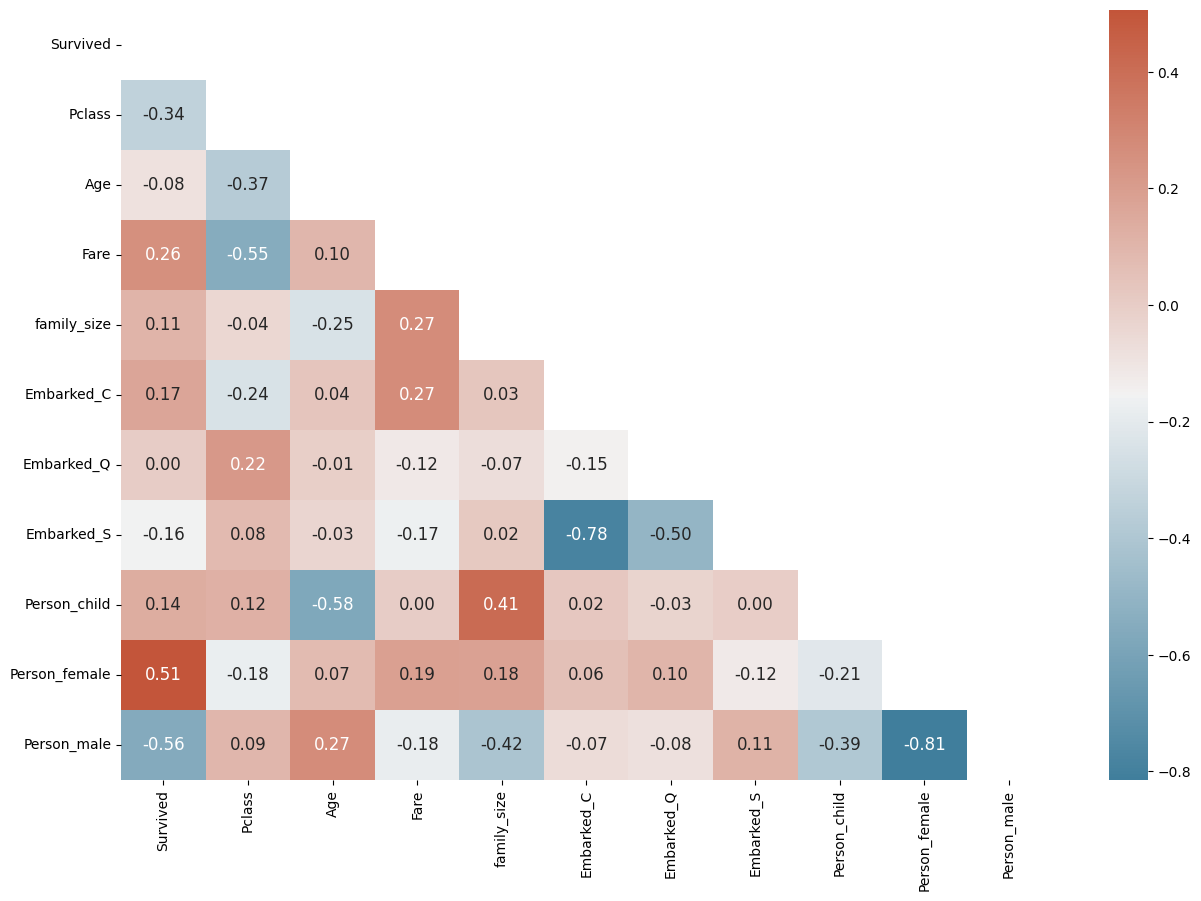

In [32]:
import matplotlib.pyplot as plt

def correlation_analysis(df):
    ''' visualise the correlation matrix'''
    # Correlation matrix
    df_num = df.select_dtypes(include=[np.number])
    # Compute the correlation matrix
    corr = df_num.corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 10))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap with the mask
    sns.heatmap(corr, annot=True, mask=mask, cmap=cmap,
                fmt='.2f', cbar=True, annot_kws={"size": 12})
    # unstack the matrix
    corr_unstacked = corr.unstack()
    # Convert the Series to a DataFrame and reset the index
    corr_df = pd.DataFrame(corr_unstacked).reset_index()
    corr_df.columns = ['Feature1', 'Feature2', 'Correlation']
    # Remove self-correlations (correlation of a feature with itself)
    corr_df = corr_df[corr_df['Feature1'] != corr_df['Feature2']]
    # Get the absolute values of the correlations
    corr_df['Correlation'] = corr_df['Correlation'].abs()
    # Sort the DataFrame by absolute correlation values in descending order
    corr_df = corr_df.sort_values(by='Correlation', ascending=False)
    corr_df['sorted_features'] = corr_df.apply(lambda row: tuple(
        sorted([row['Feature1'], row['Feature2']])), axis=1)
    corr_df = corr_df.drop_duplicates(subset=['sorted_features'])
    return corr_df

correlation_ = correlation_analysis(df_reduced)

# Model Building 

Steps taken for part this would be: <br>
1. Split data into test and train by 80:20 ratio.
2. Build a baseline Logistic Regression model.
3. Tune the hyperparameters with gridsearch
4. Build a Logistic Regression model with the tuned hyperparameters

In [33]:
# separate the target as y
y = df_reduced['Survived']
# get X by dropping column id and 'Response' from df
x = df_reduced.drop(columns=['Survived'])

# Split to train and test set by 80/20
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=0)

print(f'Training set size: {x_train.shape}, {y_train.shape}')
print(f'Testing set size: {x_test.shape}, {y_test.shape}')

Training set size: (712, 10), (712,)
Testing set size: (179, 10), (179,)


## Build Logistic Regression base model

In [34]:
# default max iter is 100, we set to 1000 for the model to be able to converge and get optimal solution
basemodel_LR = LogisticRegression(max_iter=1000)
basemodel_LR.fit(x_train, y_train)

# fit the model to the test data
y_pred_LRbase = basemodel_LR.predict(x_test)
accuracy_LRbase = accuracy_score(y_test, y_pred_LRbase)
print('Baseline Logistic Regression Test Accuracy:', accuracy_LRbase)

Baseline Logistic Regression Test Accuracy: 0.8435754189944135


## Hyperparameter Tuning

In [35]:
# Grid searching key hyperparametres for logistic regression

# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['None', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)

# define search
search = GridSearchCV(estimator=basemodel_LR, param_grid=space, scoring='accuracy', n_jobs=-1, cv=cv)

# execute search
result = search.fit(x_train, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8280712050078247
Best Hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


In [36]:
model_LRtuned = result.best_estimator_
model_LRtuned

LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='liblinear')

From the gridsearch we get the parameters and accuracy as follows: <br>
Best Score: 0.8304707876890975 <br>
Best Hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

## Train the model

In [37]:
# train the model
model_LRtuned.fit(x_train, y_train)
# fit the model to the test data
y_pred_LRtuned = model_LRtuned.predict(x_test)
accuracy_LRtuned = accuracy_score(y_test, y_pred_LRtuned)
print('Tuned Logistic Regression Test Accuracy:', accuracy_LRtuned)


Tuned Logistic Regression Test Accuracy: 0.8435754189944135


## Make predictions on submission data

Before we make predictions on the submission data, we will preprocess the submission data first.

In [38]:
# extraxt ids
test_ids = df_test["PassengerId"]

In [39]:
# preprocess the submission dataset
df_test = cal_transform_family_size(df_test)
df_test = add_person_column(df_test)
df_test= preprocess_data(df_test)
df_test.head(5)

,Pclass,Age,Fare,family_size,Embarked_C,Embarked_Q,Embarked_S,Person_child,Person_female,Person_male
0,1.0,0.452723,0.015282,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.617566,0.013663,0.5,0.0,0.0,1.0,0.0,1.0,0.0
2,0.5,0.815377,0.018909,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.353818,0.016908,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,0.287881,0.023984,0.5,0.0,0.0,1.0,0.0,1.0,0.0


In [40]:
# fit the model to the test data
y_submission = model_LRtuned.predict(df_test)

In [41]:
y_submission

array([0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1.

In [42]:
submission = pd.DataFrame({"PassengerId" : test_ids , "Survived" : y_submission})
submission.to_csv("submission.csv" , index= False)